Import libraries and Tensorflow framework with Keras API.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from langdetect import detect
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Dense, Dropout, LSTM
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/armh12/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/armh12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read data.

In [8]:
train = pd.read_csv('Corona_NLP_train.csv', encoding_errors = 'ignore')
test = pd.read_csv('Corona_NLP_test.csv', encoding_errors = 'ignore')
display(train.head(), test.head())
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Train shape: (41157, 6)
Test shape: (3798, 6)


In [9]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+

EDA and feature engineering part.

Train isnull values:  UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64
Test isnull values:  UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


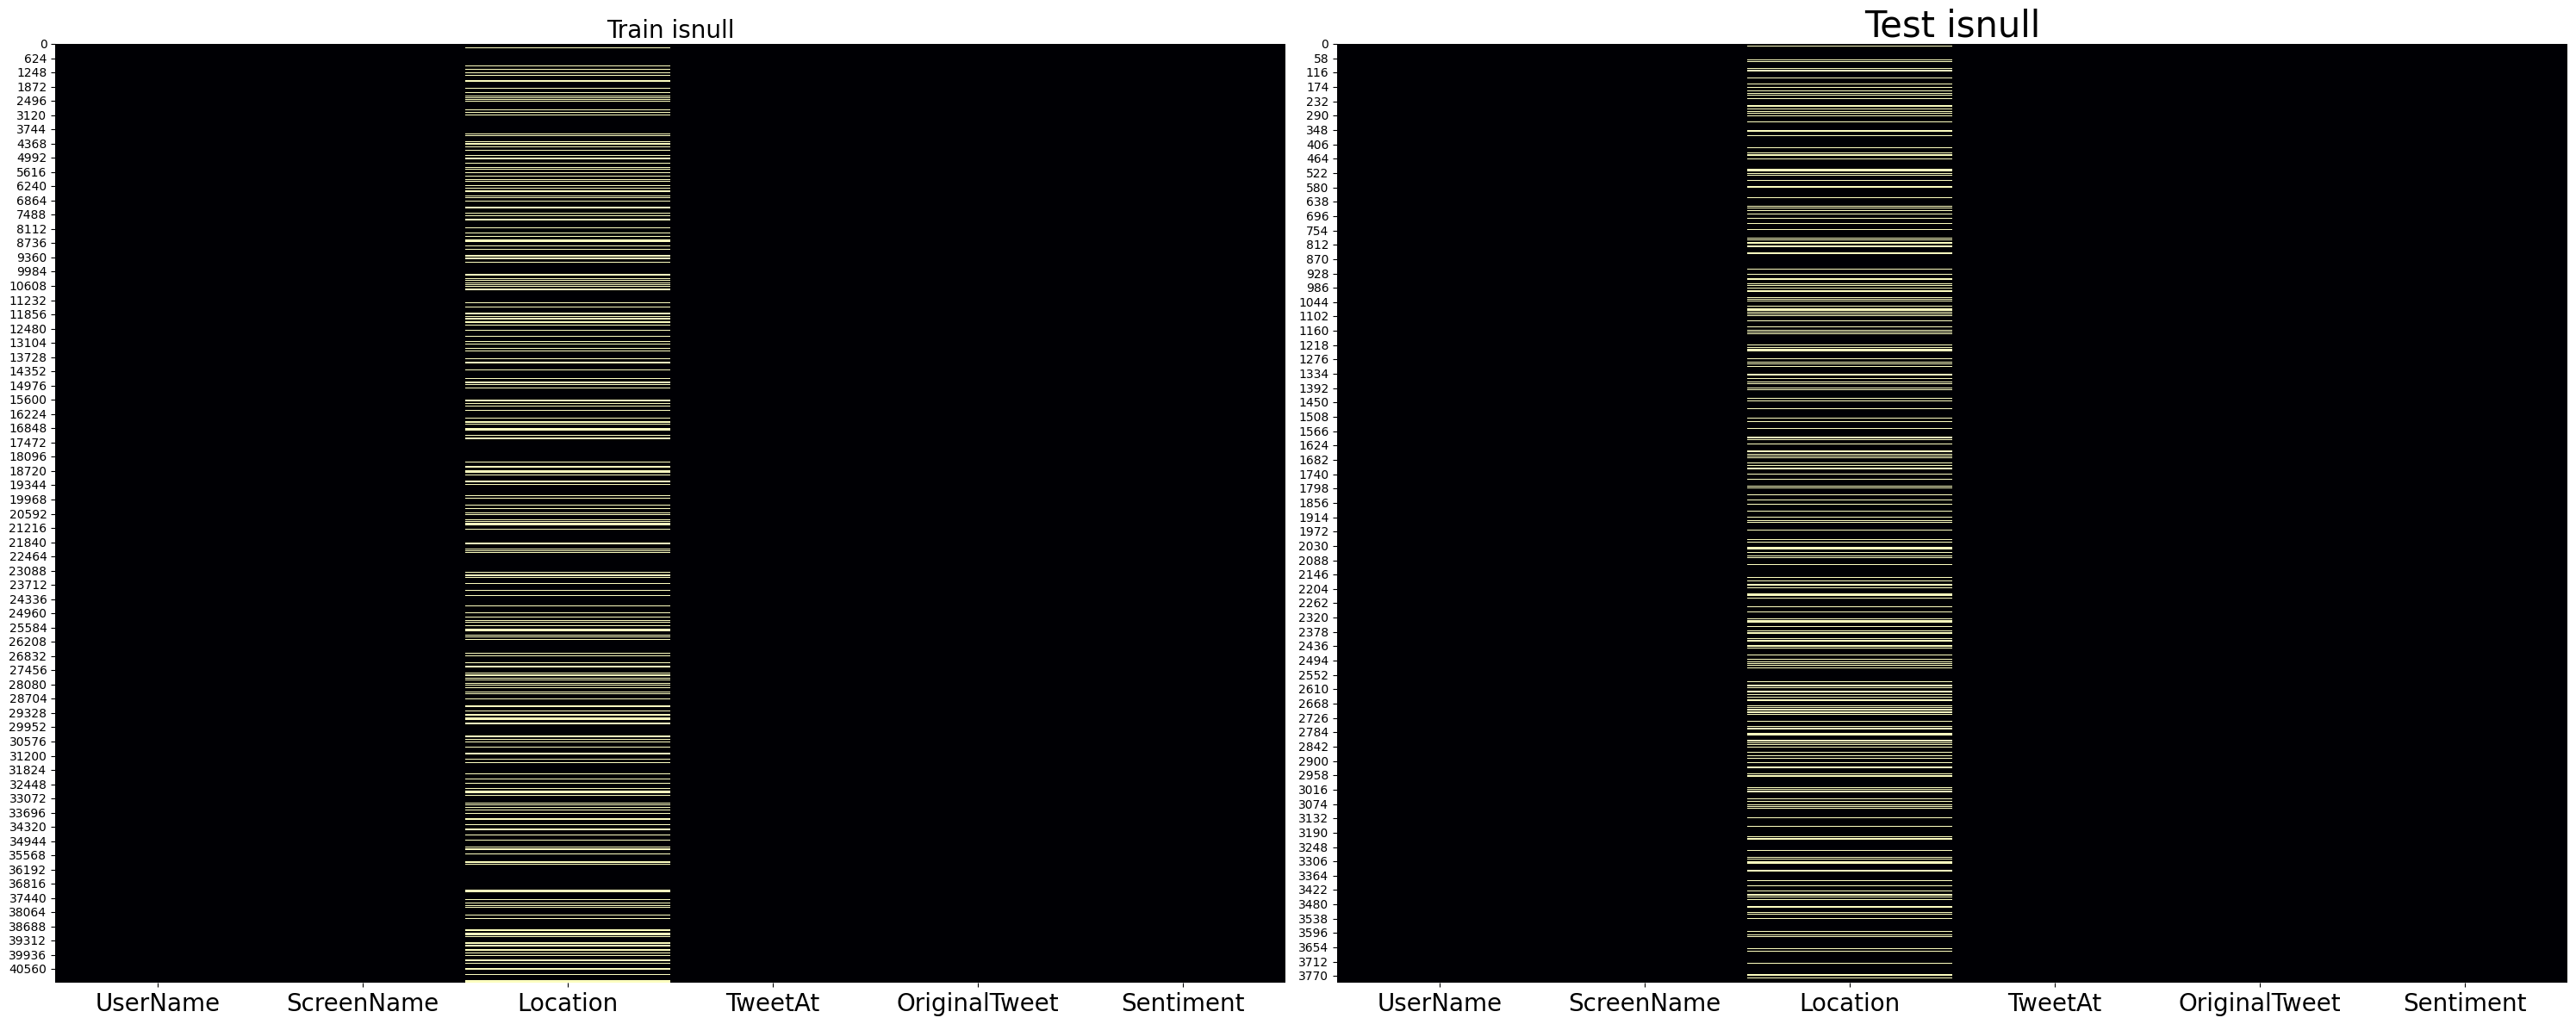

In [10]:
# looking through null values specifically

print('Train isnull values: ', train.isnull().sum())
print('Test isnull values: ', test.isnull().sum())

# subplot settings
n_rows = 1
n_cols = 2
plt.figure(figsize = (30,12));

plt.subplot(1,2,1)
sns.heatmap(data = train.isnull(), cmap = 'magma', cbar = False)
plt.xticks(fontsize = 20)
plt.title('Train isnull', fontsize = 20)

plt.subplot(1,2,2)
sns.heatmap(data = test.isnull(), cmap = 'magma', cbar = False)
plt.xticks(fontsize = 20)
plt.title('Test isnull', fontsize = 30)

plt.tight_layout()
plt.show();

Sentiment is our target so let's look at his categories.

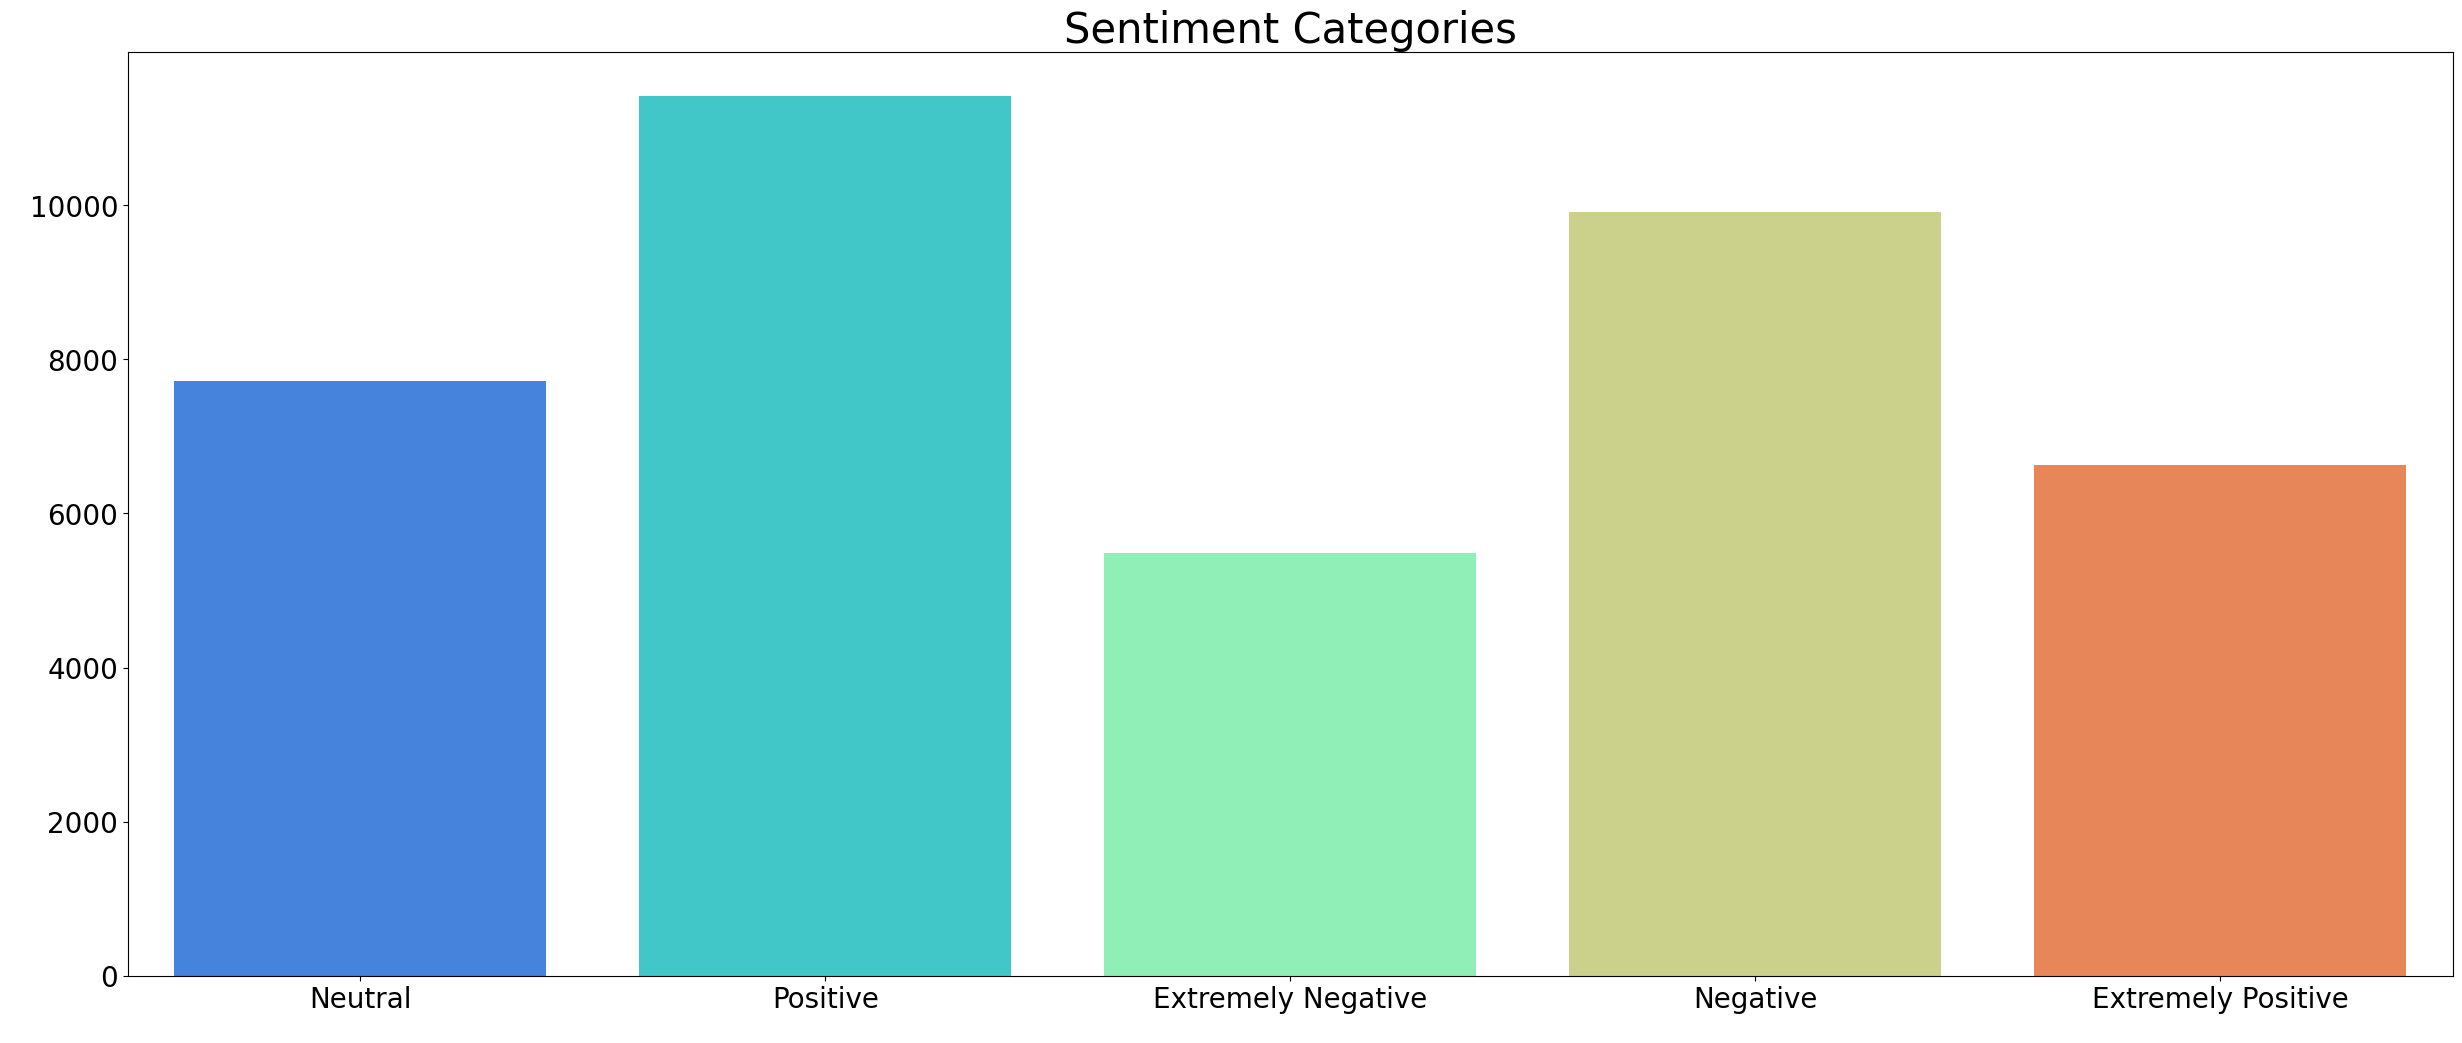

In [11]:
plt.figure(figsize = (30,12))
plt.title('Sentiment Categories', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(' ')
plt.ylabel(' ')
sns.countplot(data = train, x = 'Sentiment', palette = 'rainbow')
plt.show();

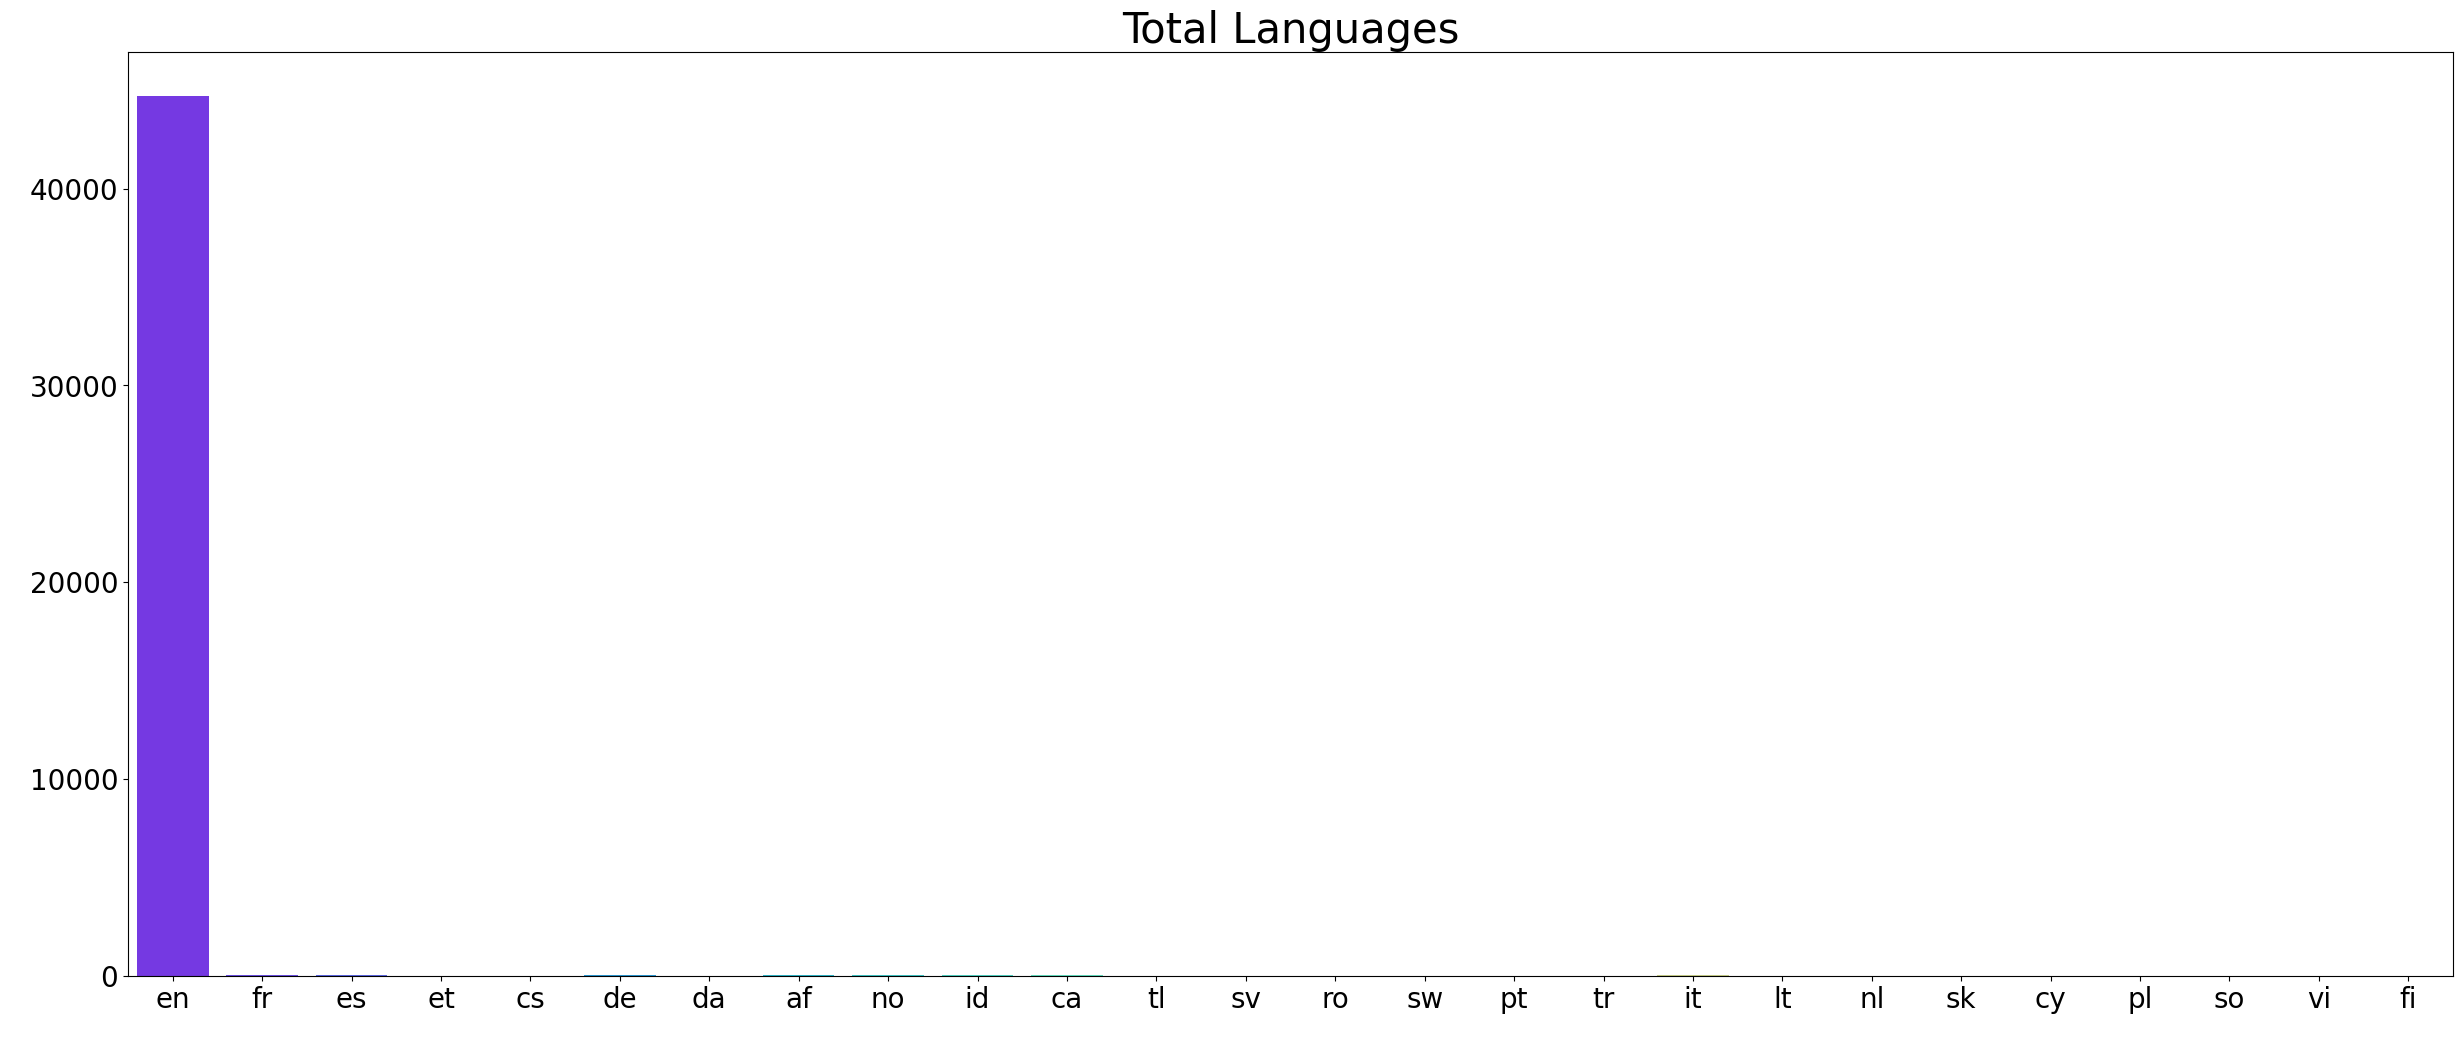

In [12]:
# checking which languages do we have using language detection package
def detect_language(text):
    try:
        return detect(text) if text.strip() else np.nan
    except Exception:
        pass

lang_detect = pd.DataFrame(pd.concat([train, test], axis = 0, ignore_index = True)['OriginalTweet'].apply(detect_language))
# plotting results
plt.figure(figsize = (30,12))
plt.title('Total Languages', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(' ')
plt.ylabel(' ')
sns.countplot(data = lang_detect, x = 'OriginalTweet', palette = 'rainbow')
plt.show();

In [13]:
lang_detect.value_counts()

OriginalTweet
en               44722
fr                  35
es                  25
de                  23
it                  19
ca                  14
id                  14
no                  13
af                  13
nl                   8
tl                   8
ro                   7
tr                   6
pt                   5
da                   5
et                   5
sv                   4
sw                   3
fi                   2
cs                   2
cy                   2
vi                   2
pl                   1
lt                   1
so                   1
sk                   1
Name: count, dtype: int64

In [14]:
# making column of languages for taking only english tweets
train['Language'] = train.OriginalTweet.apply(detect_language)
test['Language'] = test.OriginalTweet.apply(detect_language)

In [15]:
train = train.loc[train.Language == 'en', :]
test = test.loc[test.Language == 'en', :]
print(f'Train shape after removing non-english tweets: {train.shape}')
print(f'Test shape after removing non-english tweets: {test.shape}')

Train shape after removing non-english tweets: (40940, 7)
Test shape after removing non-english tweets: (3788, 7)


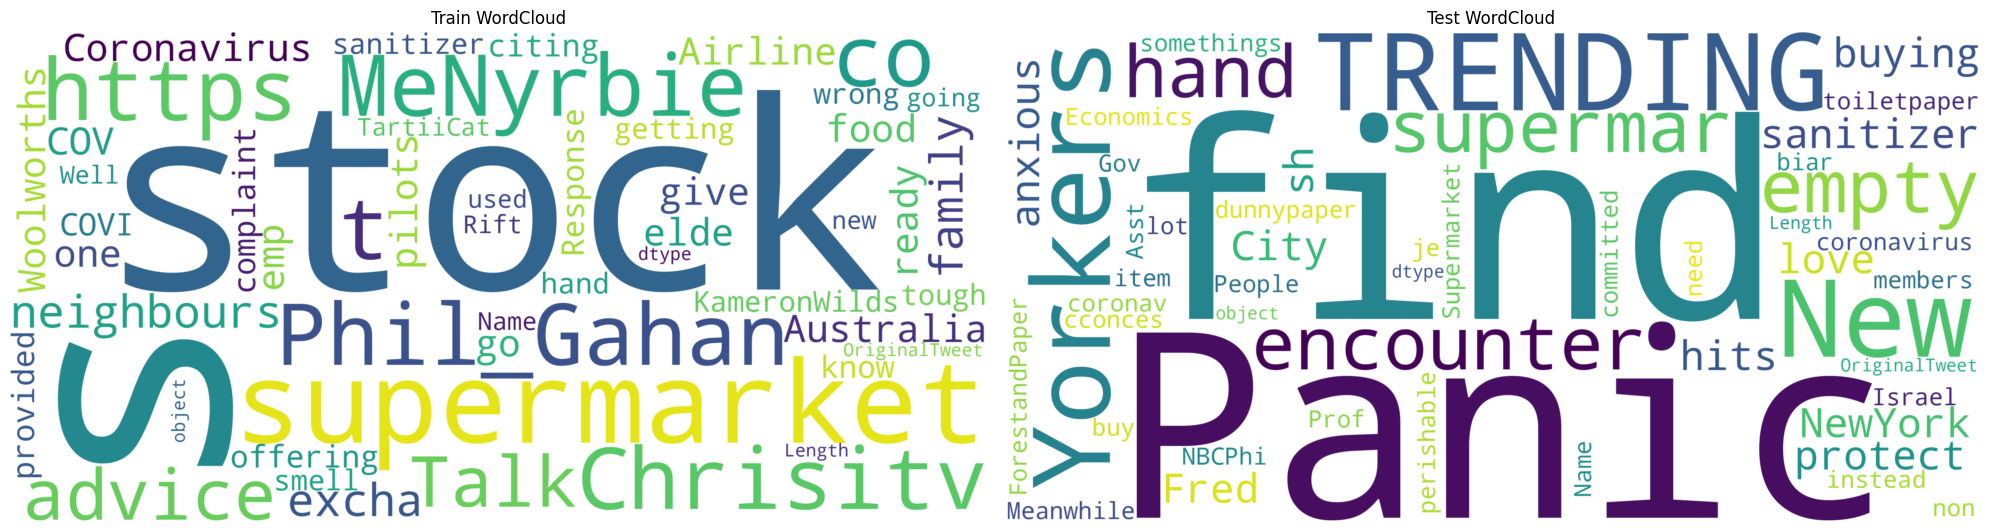

In [16]:
# WordCloud for looking to most frequent words
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
wordcloud_1 = WordCloud(width = 3000, height = 1500, background_color = 'white').generate(str(train['OriginalTweet']))
plt.imshow(wordcloud_1, interpolation = 'bilinear')
plt.axis('off')
plt.title('Train WordCloud')

plt.subplot(1,2,2)
wordcloud_2 = WordCloud(width = 3000, height = 1500, background_color = 'white').generate(str(test['OriginalTweet']))
plt.imshow(wordcloud_2, interpolation = 'bilinear')
plt.axis('off')
plt.title('Test WordCloud')

plt.tight_layout()
plt.show();

Data Preparation.

In [17]:
# X and y
X_train = train[['OriginalTweet']]
X_test = test[['OriginalTweet']]
y_train = train['Sentiment']
y_test = test['Sentiment']
# label encoding of y-s
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train, y_test, X_train, X_test)

# hot encoding for better perfomance
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

[3 4 4 ... 4 3 2] [0 4 1 ... 3 0 1]                                            OriginalTweet
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1      advice Talk to your neighbours family to excha...
2      Coronavirus Australia: Woolworths to give elde...
3      My food stock is not the only one which is emp...
4      Me, ready to go at supermarket during the #COV...
...                                                  ...
41152  Airline pilots offering to stock supermarket s...
41153  Response to complaint not provided citing COVI...
41154  You know its getting tough when @KameronWilds...
41155  Is it wrong that the smell of hand sanitizer i...
41156  @TartiiCat Well new/used Rift S are going for ...

[40940 rows x 1 columns]                                           OriginalTweet
0     TRENDING: New Yorkers encounter empty supermar...
1     When I couldn't find hand sanitizer at Fred Me...
2     Find out how you can protect yourself and love...
3     #Panic buying hits #NewY

0 - Extremely Negative

1 - Extremely Positive

2 - Negative

3 - Neutral

4 - Positive

We need to tokenize and pad our data.

In [18]:
# method for applying nltk tokenizing on OriginalTweet columns
def preprocess_nltk(text):
    # tokenizing by using nltk library
    tokens = word_tokenize(text)
    # making words lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # define stop words in most common languages
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # return tokens combined as text
    return ' '.join(tokens)

In [19]:
# apply method above to tokenize and join words with nltk
X_train['ProcessedText'] = X_train['OriginalTweet'].apply(preprocess_nltk)
X_test['ProcessedText'] = X_test['OriginalTweet'].apply(preprocess_nltk)

# tokenizing tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.ProcessedText)
X_train_tok = tokenizer.texts_to_sequences(X_train.ProcessedText)
X_test_tok = tokenizer.texts_to_sequences(X_test.ProcessedText)

# chechking maximum length of each sequence for padding
maximum_length_train = max([len(x) for x in X_train_tok])
maximum_length_test = max([len(x) for x in X_test_tok])

print(f'Biggest length in train: {maximum_length_train}')
print(f'Biggest length in test: {maximum_length_test} \n')

# padding
X_train_pad = pad_sequences(X_train_tok, maxlen = max(maximum_length_train, maximum_length_test), padding = 'post')
X_test_pad = pad_sequences(X_test_tok, maxlen = max(maximum_length_train, maximum_length_test), padding = 'post')
print(X_train_pad, '\n\n\n', X_test_pad)

Biggest length in train: 40
Biggest length in test: 39 

[[21124 12147     1 ...     0     0     0]
 [  391   749  2393 ...     0     0     0]
 [    2   635  1624 ...     0     0     0]
 ...
 [   55   134  1471 ...     0     0     0]
 [  583  3987    27 ...     0     0     0]
 [48510   121 48511 ...     0     0     0]] 


 [[ 1992    32  5392 ...     0     0     0]
 [   62   114    27 ...     0     0     0]
 [  114   192  1605 ...     0     0     0]
 ...
 [ 5369  1877 19652 ...     0     0     0]
 [  819    16 18766 ...     0     0     0]
 [  684  2335   293 ...     0     0     0]]


Let's build our Sequential model using Embeddings and Bidirectional layers to classify sentiments.

In [35]:
model = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 50, input_length = maximum_length_train, name = 'emb_layer'),
    LSTM(64),
    Dropout(0.2),
    Dense(5, activation = 'softmax'),
])

model.compile(optimizer = 'adam',
              loss = keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])
# early stop for stopping on best accuracy score based on validation split
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

model_history = model.fit(X_train_pad, y_train_cat, validation_split = 0.1, epochs = 15, callbacks = early_stop)

Epoch 1/15
1152/1152 [==============================] - 24s 20ms/step - loss: 1.3125 - accuracy: 0.4316 - val_loss: 0.9198 - val_accuracy: 0.6417
Epoch 2/15
1152/1152 [==============================] - 13s 12ms/step - loss: 0.7441 - accuracy: 0.7288 - val_loss: 0.7407 - val_accuracy: 0.7269
Epoch 3/15
1152/1152 [==============================] - 13s 11ms/step - loss: 0.5179 - accuracy: 0.8309 - val_loss: 0.7813 - val_accuracy: 0.7211
Epoch 4/15
1152/1152 [==============================] - 13s 11ms/step - loss: 0.3891 - accuracy: 0.8814 - val_loss: 0.8196 - val_accuracy: 0.7335
Epoch 5/15
1152/1152 [==============================] - 12s 11ms/step - loss: 0.3048 - accuracy: 0.9096 - val_loss: 0.9345 - val_accuracy: 0.7142
Epoch 6/15
1152/1152 [==============================] - 13s 11ms/step - loss: 0.2415 - accuracy: 0.9303 - val_loss: 0.9629 - val_accuracy: 0.7198
Epoch 7/15
1152/1152 [==============================] - 13s 11ms/step - loss: 0.2003 - accuracy: 0.9428 - val_loss: 1.0684 -

Evaluate model and see plot training results.

In [36]:
model.evaluate(X_test_pad, y_test_cat)

119/119 [==============================] - 2s 14ms/step - loss: 0.9717 - accuracy: 0.6903


[0.971720278263092, 0.6903378963470459]

Training - 96 %,
Test - 69 %,
Validation - 69 %

It seems we have overfitting.

In [39]:
# making y predicted labels
y_pred = model.predict(X_test_pad)
y_pred_labels = [np.argmax(elem) for elem in y_pred]
print(y_pred_labels)

119/119 [==============================] - 1s 6ms/step
[2, 4, 1, 0, 3, 3, 4, 2, 2, 4, 4, 0, 0, 4, 4, 4, 4, 3, 4, 1, 2, 4, 4, 4, 0, 4, 3, 2, 0, 2, 2, 1, 2, 0, 4, 0, 2, 0, 4, 1, 4, 2, 2, 4, 2, 1, 1, 2, 0, 0, 0, 3, 2, 1, 0, 3, 2, 4, 2, 3, 0, 2, 4, 0, 4, 4, 2, 1, 4, 1, 2, 1, 4, 0, 4, 0, 2, 4, 4, 4, 0, 0, 1, 4, 4, 2, 3, 3, 4, 2, 2, 3, 4, 0, 2, 1, 3, 1, 0, 3, 4, 3, 2, 4, 3, 1, 4, 2, 2, 0, 2, 1, 1, 3, 1, 2, 2, 1, 2, 3, 4, 4, 4, 2, 2, 2, 4, 1, 2, 0, 2, 4, 0, 2, 2, 1, 4, 4, 4, 2, 1, 1, 2, 4, 4, 4, 2, 2, 2, 4, 4, 1, 4, 4, 3, 2, 2, 2, 2, 0, 4, 4, 4, 3, 3, 3, 2, 2, 4, 4, 2, 1, 3, 4, 0, 4, 3, 4, 2, 3, 3, 1, 2, 4, 2, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 4, 3, 1, 4, 2, 4, 2, 4, 1, 4, 0, 3, 1, 3, 4, 0, 2, 2, 4, 1, 2, 2, 3, 3, 2, 3, 4, 4, 2, 1, 4, 4, 2, 2, 0, 0, 1, 4, 3, 2, 4, 4, 3, 3, 4, 1, 4, 2, 2, 0, 0, 4, 3, 3, 2, 3, 3, 4, 1, 4, 4, 4, 4, 1, 0, 2, 4, 0, 2, 2, 2, 4, 0, 2, 2, 3, 1, 3, 2, 4, 1, 2, 2, 4, 2, 1, 3, 4, 4, 0, 4, 4, 3, 0, 0, 2, 2, 4, 0, 2, 1, 4, 4, 4, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 3, 4, 2, 2, 2,

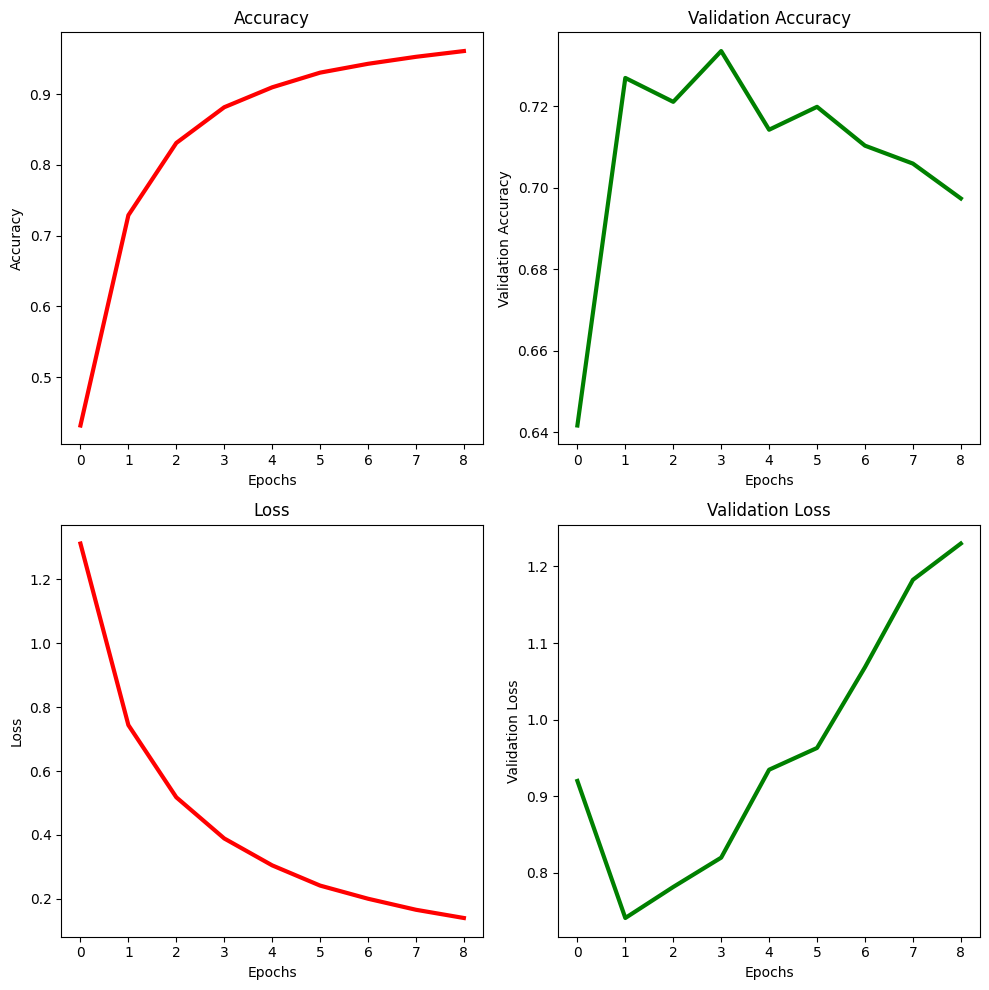

In [47]:
# plot of changing accuracy and loss of training and validation splits for each epoch
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
plot_titles_list = ['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss']
plot_topics_list = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
colors = ['red', 'green']
for ax_i, title in enumerate(plot_titles_list):
    row = ax_i // 2
    col = ax_i % 2
    ax = axes[row, col]
    sns.lineplot(model_history.history[plot_topics_list[ax_i]], ax = ax, color = colors[ax_i % 2], lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(plot_titles_list[ax_i])
    ax.set_title(plot_titles_list[ax_i])
plt.tight_layout()
plt.show();

                    precision    recall  f1-score   support

Extremely Negative       0.79      0.59      0.68       592
Extremely Positive       0.85      0.66      0.74       599
          Negative       0.62      0.67      0.64      1040
           Neutral       0.79      0.72      0.75       611
          Positive       0.61      0.78      0.69       946

          accuracy                           0.69      3788
         macro avg       0.73      0.68      0.70      3788
      weighted avg       0.71      0.69      0.69      3788



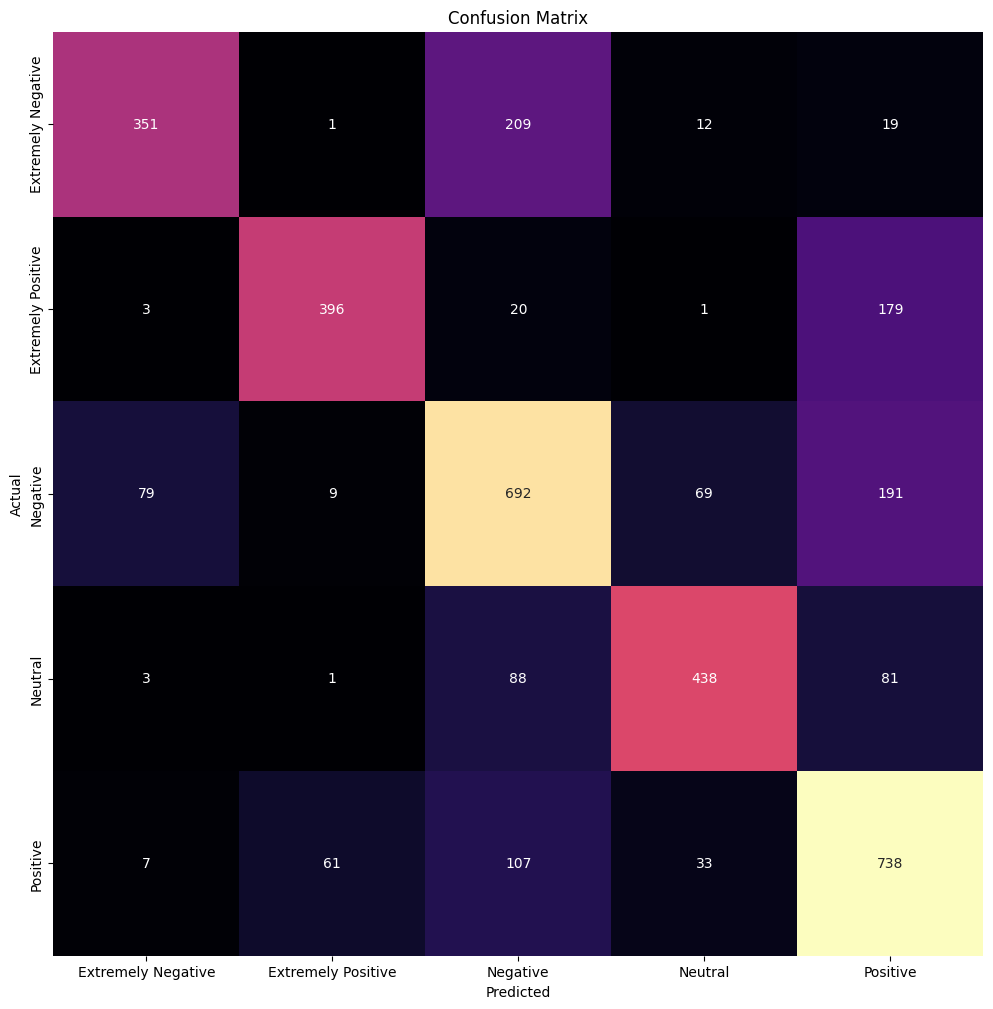

In [61]:
# classification report and confusion matrix
label_names = ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral','Positive']
print(classification_report(y_test, y_pred_labels, 
                            target_names = label_names))

plt.figure(figsize = (12,12))
sns.heatmap(data = confusion_matrix(y_test, y_pred_labels), cmap = 'magma', cbar = False, annot = True, fmt = 'd',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show();

I did a lot of experiments with this data, and these are the best results that I could achieve.With this notebook, I wanted to use my knowledge in NLP techniques such as tokenazation and recurent neural networks, the goal was not about to achieve best results.We had some overfitting, but we could achieve 69% of accuracy for test split, which is pretty average.BTW, I will use BERT and other techniques, such as vectorazation(which is simillar to which we did in this notebook), to see, can we receive better results.